<a href="https://colab.research.google.com/github/ViniciusKanh/Digital-Surveillance-Vigilante-Inteligente/blob/main/Digital_Surveillance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

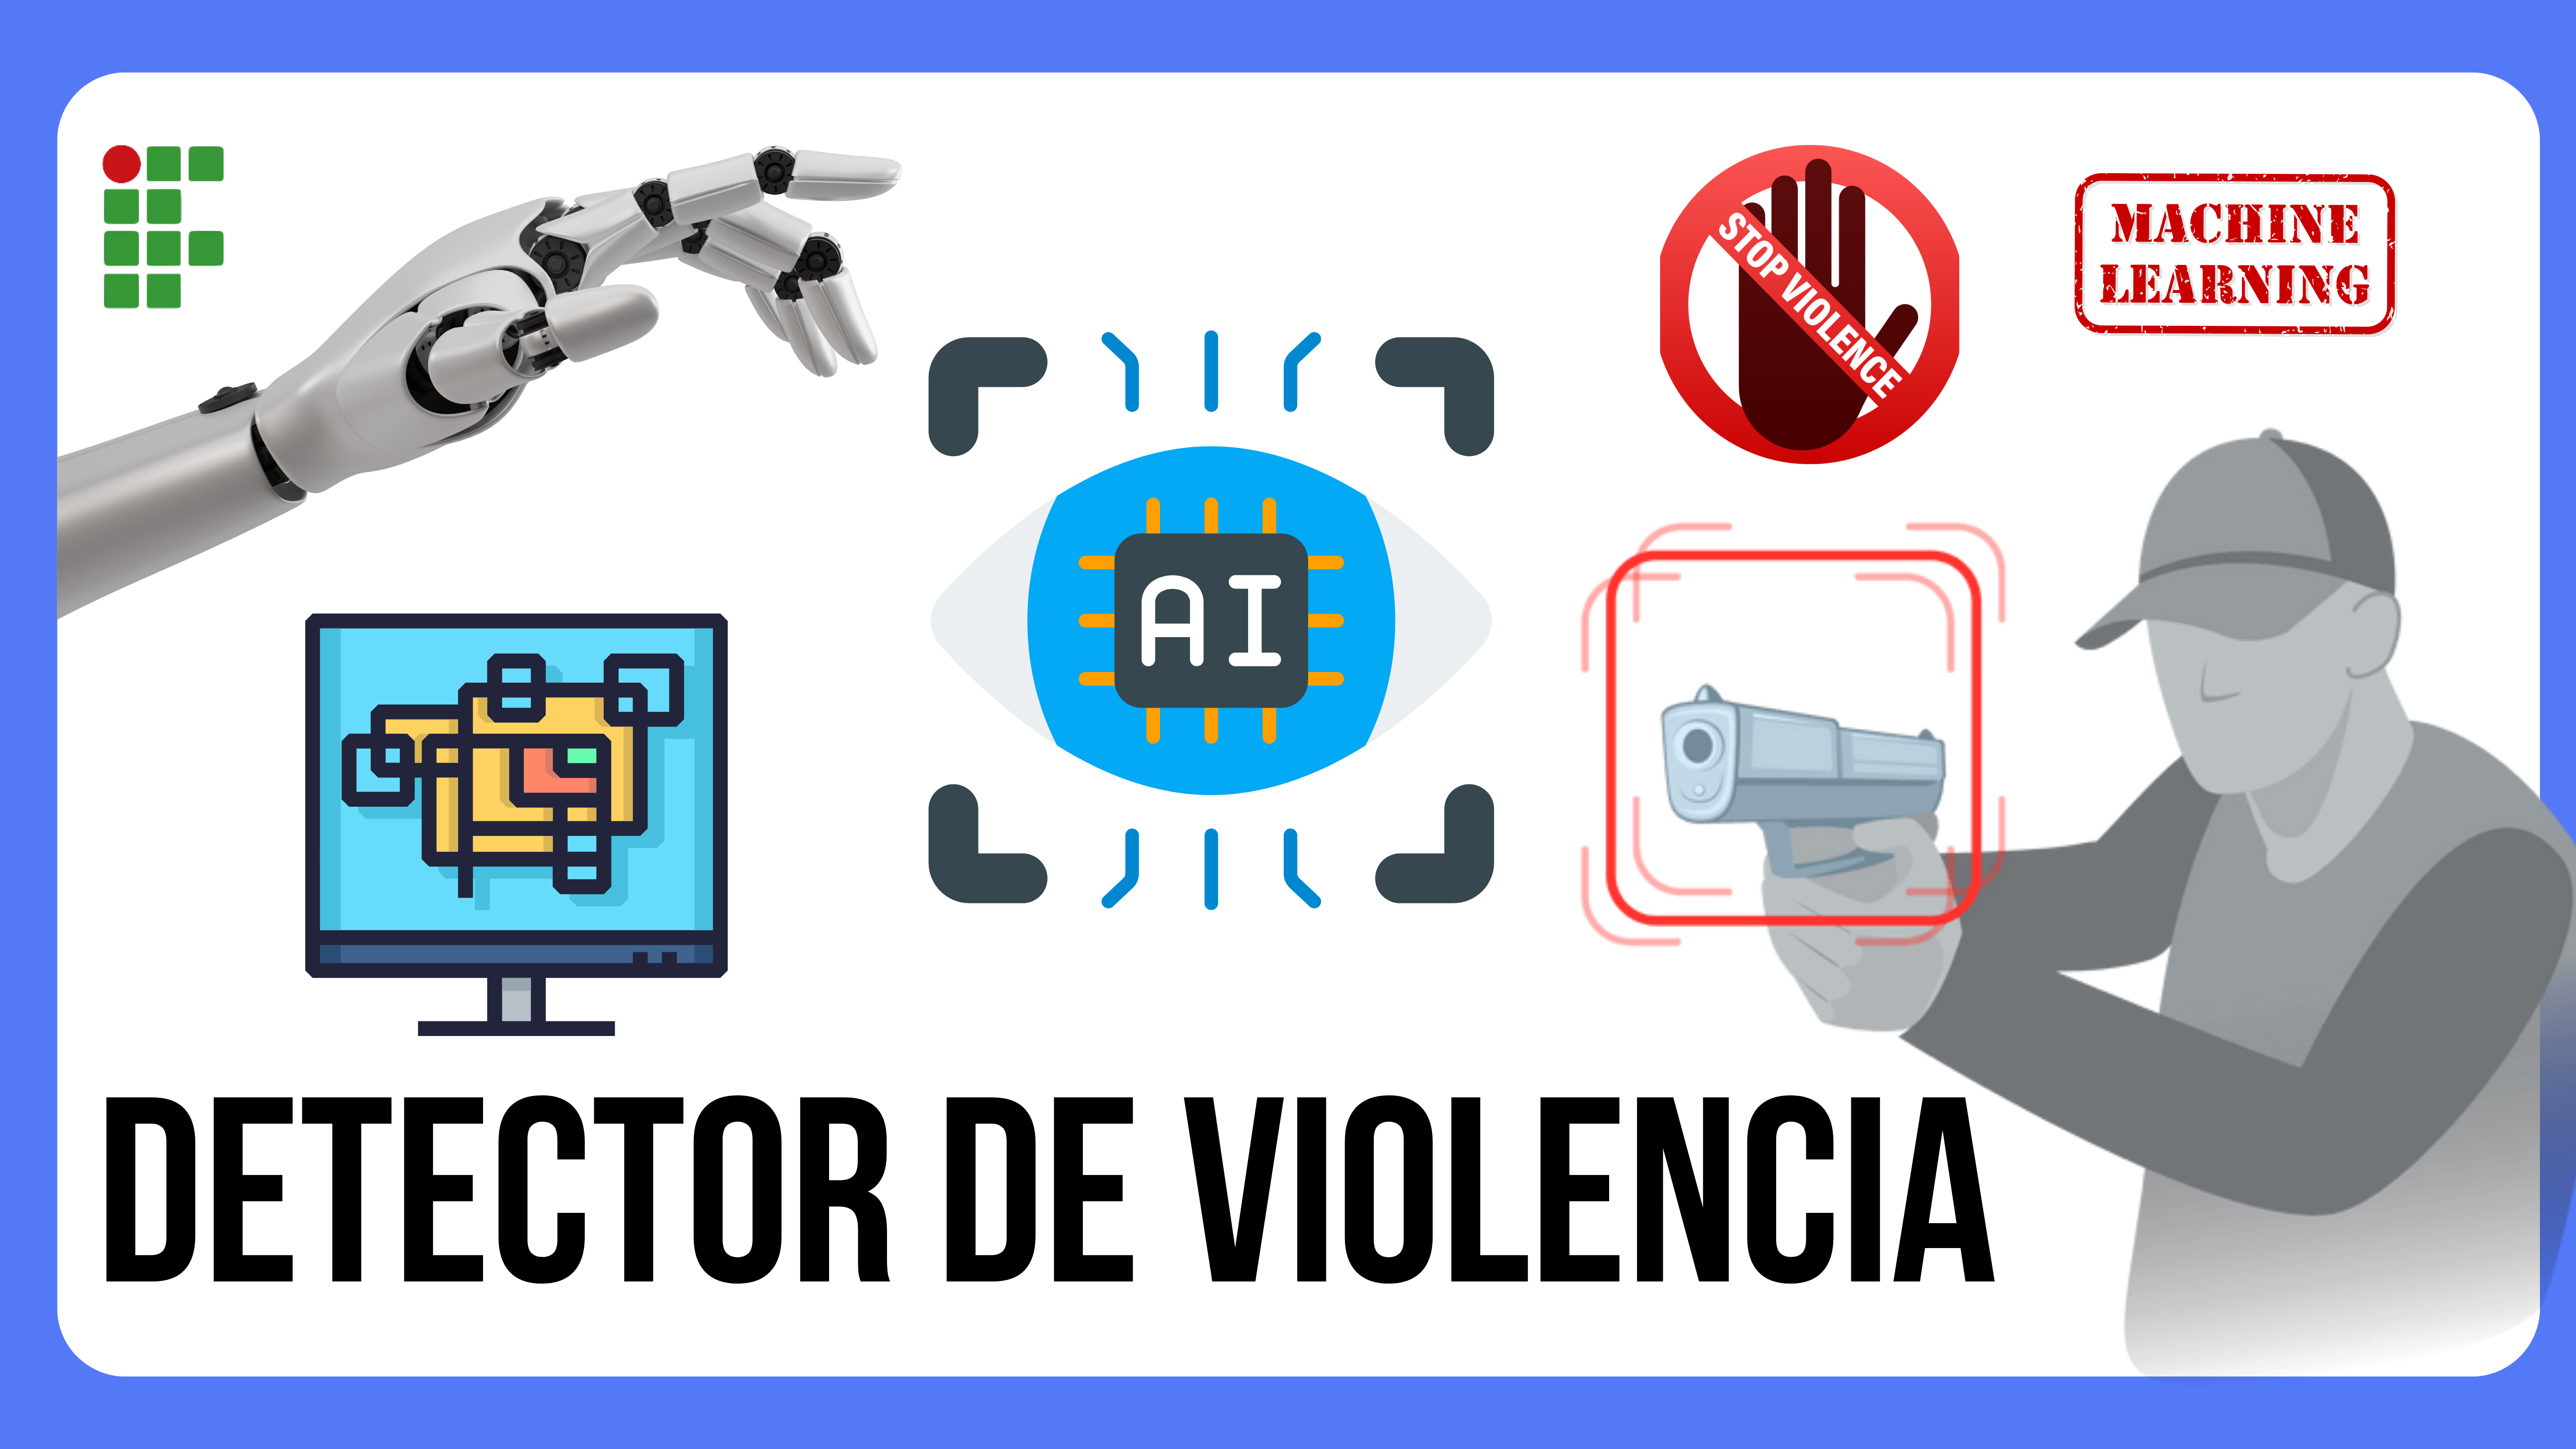
# Vigilante Digital - Reconhecimento de Violência Através de Imagem

# Projeto de Pesquisa: Vigilante Digital - Reconhecimento de Violência Através de Imagem

## Resumo

O projeto "Vigilante Digital: Reconhecimento de Violência Através de Imagem" visa desenvolver um sistema de Inteligência Artificial (IA) capaz de identificar situações de violência em imagens. Utilizando técnicas avançadas de aprendizado de máquina e processamento de imagens, o projeto busca oferecer uma ferramenta eficaz para a identificação precoce de atos violentos, contribuindo para medidas de prevenção e segurança.

## Introdução

A detecção de violência através de imagens é um campo desafiador, que envolve não apenas o reconhecimento de padrões complexos e variados, mas também questões éticas e de privacidade. O objetivo deste projeto é criar um modelo de IA que possa analisar imagens e identificar potenciais situações de violência com precisão e eficiência.

### Justificativa

O reconhecimento automático de violência em imagens tem aplicações significativas em segurança pública, monitoramento de redes sociais e em sistemas de vigilância. A automação desse processo pode auxiliar na rápida identificação e resposta a incidentes violentos.

### Objetivos

1. Desenvolver um modelo de IA utilizando redes neurais convolucionais (CNNs) para identificar violência em imagens.
2. Realizar uma análise comparativa de diferentes arquiteturas de CNNs em termos de precisão e eficiência.
3. Avaliar a performance do modelo em um conjunto de dados diversificado.

## Metodologia

### Conjunto de Dados

Utilizaremos o dataset "Violence vs. Non-Violence: 11K Images Dataset" disponível no Kaggle, que inclui mais de 11.000 imagens categorizadas em "violência" e "não violência".

### Ferramentas e Tecnologias

- Google Colab para desenvolvimento e treinamento dos modelos.
- Linguagens de programação: Python.
- Bibliotecas: TensorFlow, Keras, OpenCV, entre outras.

### Etapas do Projeto

1. **Análise Exploratória de Dados**: Entender a distribuição e natureza das imagens no dataset.
2. **Pré-processamento de Dados**: Inclui redimensionamento, normalização e aumento de dados.
3. **Modelagem**: Desenvolvimento de modelos CNN utilizando arquiteturas como VGG16 e YOLOv3.
4. **Treinamento e Validação**: Treinar os modelos e validar usando um conjunto de dados separado.
5. **Teste**: Avaliar o modelo com um conjunto de dados de teste para verificar a precisão e outras métricas.
6. **Otimização e Ajustes**: Refinar o modelo com base nos resultados dos testes.
7. **Documentação e Relatório**: Documentar todo o processo e resultados.

## Resultados Esperados

Espera-se que o modelo desenvolvido seja capaz de identificar com precisão situações de violência em imagens, superando as métricas de desempenho estabelecidas no início do projeto.

## Considerações Éticas

O projeto deve considerar questões éticas relacionadas à privacidade e ao uso responsável da tecnologia de reconhecimento de imagem.

## Conclusão

O "Vigilante Digital: Reconhecimento de Violência Através de Imagem" tem o potencial de ser uma ferramenta valiosa na identificação e prevenção de violência, utilizando o poder da IA para criar ambientes mais seguros.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Importando Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model

## Caminho do dataset

In [ ]:
!ls "/content/drive/My Drive/0-Dataset/Digital Surveillance/"

assets		   DetectViolence.spec	MobileNetV3Small.h5	 test.txt
build		   dist			new_violence		 train.txt
DetectViolence.py  MobileNetV3Small	nome_do_seu_script.spec


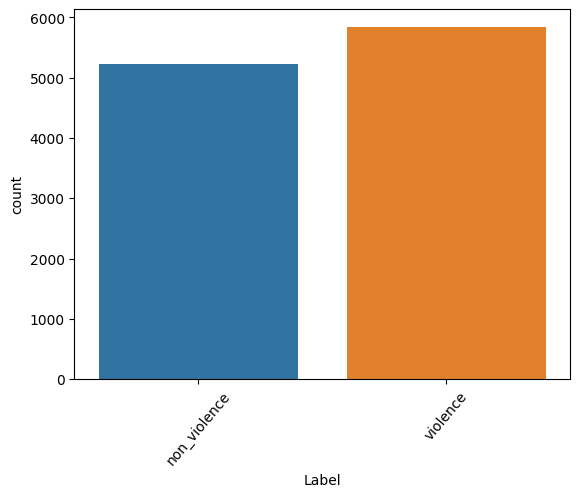

In [ ]:
image_data = '/content/drive/My Drive/0-Dataset/Digital Surveillance/new_violence'

labels = []
files = []
for class_dir in os.listdir(image_data):
    class_dir_path = os.path.join(image_data, class_dir)
    if os.path.isdir(class_dir_path):
        for img_file in os.listdir(class_dir_path):
            files.append(os.path.join(class_dir_path, img_file))
            labels.append(class_dir)

dataframe = pd.DataFrame({'Image': files, 'Label': labels})
sns.countplot(x='Label', data=dataframe)
plt.xticks(rotation=50)
plt.show()

In [ ]:
non_violence_files = os.listdir(os.path.join(image_data, 'non_violence'))
violence_files = os.listdir(os.path.join(image_data, 'violence'))

print("Non-violence files:", len(non_violence_files))
print("Violence files:", len(violence_files))

Non-violence files: 0
Violence files: 0


# Dividindo os dados em conjuntos de treino e teste

In [ ]:
batch_size = 32
target_size = (224, 224)
validation_split = 0.2
train = tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size
)
validation = tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size
)

class_names = train.class_names

Found 11073 files belonging to 2 classes.
Using 8859 files for training.
Found 11073 files belonging to 2 classes.
Using 2214 files for validation.


# Visualização de Algumas Imagens

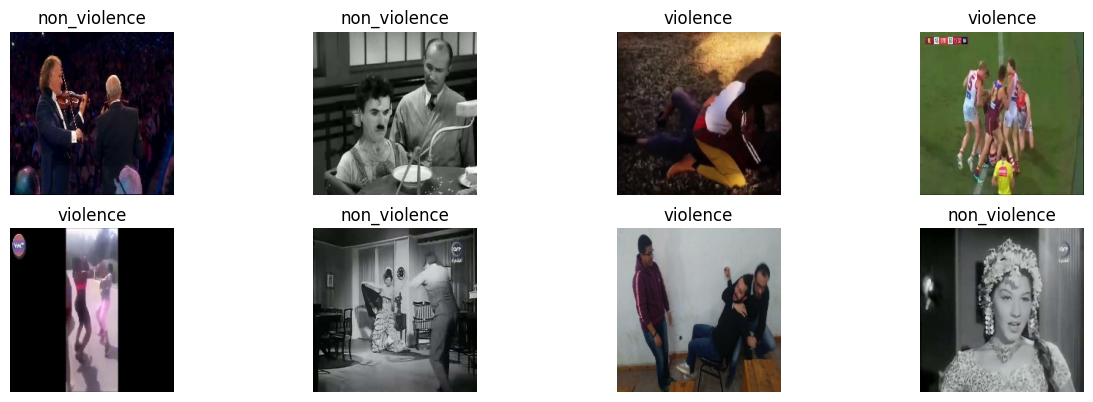

In [ ]:
plt.figure(figsize=(15, 20))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Contruindo o modelo

In [ ]:
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
keras_model = keras.models.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])
keras_model.summary()

# Visualização do Modelo
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True, show_dtype=True, dpi=80)

# Configuração de Checkpoints e Early Stopping
checkpoint = ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Compilação do Modelo
keras_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dropout (Dropout)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 2)                 56450     
                                                                 
Total params: 995570 (3.80 MB)
Trainable params: 56450 (220.51 KB)
Non-trainable params: 939120 (3.58 MB)
_________________________________________________________________


# Treinamento do modelo

In [ ]:
hist = keras_model.fit(train, epochs=20, validation_data=validation, callbacks=[checkpoint, early_stopping])

Epoch 1/20
277/277 [==============================] - 534s 2s/step - loss: 0.8933 - accuracy: 0.8785 - val_loss: 0.3363 - val_accuracy: 0.9548
Epoch 2/20
277/277 [==============================] - 159s 570ms/step - loss: 0.4317 - accuracy: 0.9488 - val_loss: 0.2019 - val_accuracy: 0.9706
Epoch 3/20
277/277 [==============================] - 173s 621ms/step - loss: 0.3935 - accuracy: 0.9568 - val_loss: 0.2040 - val_accuracy: 0.9797
Epoch 4/20
277/277 [==============================] - 181s 652ms/step - loss: 0.3381 - accuracy: 0.9649 - val_loss: 0.2027 - val_accuracy: 0.9815
Epoch 5/20
277/277 [==============================] - 172s 620ms/step - loss: 0.2637 - accuracy: 0.9725 - val_loss: 0.2499 - val_accuracy: 0.9788
Epoch 6/20
277/277 [==============================] - 174s 624ms/step - loss: 0.3187 - accuracy: 0.9716 - val_loss: 0.2054 - val_accuracy: 0.9846
Epoch 7/20
277/277 [==============================] - 172s 619ms/step - loss: 0.2624 - accuracy: 0.9776 - val_loss: 0.2055 - va

# Salvar o Modelo

In [ ]:
# Salva o modelo inteiro em um arquivo HDF5
keras_model.save('/content/drive/My Drive/0-Dataset/Digital Surveillance/DetectViolence.h5')

# Salva o modelo inteiro em um diretório específico do TensorFlow SavedModel
keras_model.save('/content/drive/My Drive/0-Dataset/Digital Surveillance/DetectViolence')

# Avaliação do Modelo


In [ ]:
score, acc = keras_model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

70/70 [==============================] - 35s 494ms/step - loss: 0.2019 - accuracy: 0.9706
Test Loss = 0.2019493132829666
Test Accuracy = 0.9706413745880127


# Histórico de Treinamento


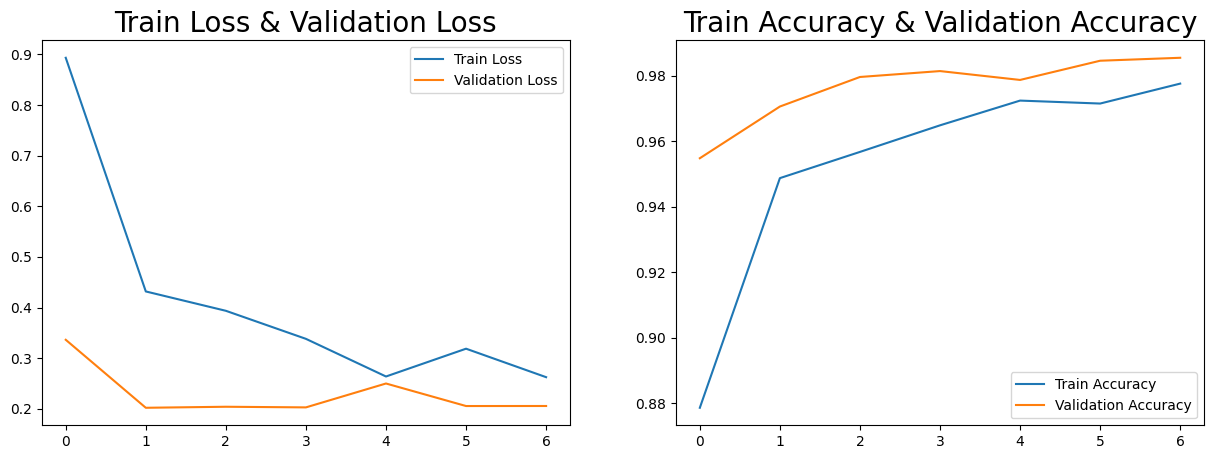

In [ ]:
hist_ = pd.DataFrame(hist.history)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_['loss'], label='Train Loss')
plt.plot(hist_['val_loss'], label='Validation Loss')
plt.title('Train Loss & Validation Loss', fontsize=20)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist_['accuracy'], label='Train Accuracy')
plt.plot(hist_['val_accuracy'], label='Validation Accuracy')
plt.title('Train Accuracy & Validation Accuracy', fontsize=20)
plt.legend()
plt.show()

# Predições e Matriz de Confusão

In [ ]:
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = keras_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))

df = pd.DataFrame()
df['Actual'], df['Prediction'] = y_val, y_pred


70/70 [==============================] - 36s 468ms/step


# Visualização das Previsões

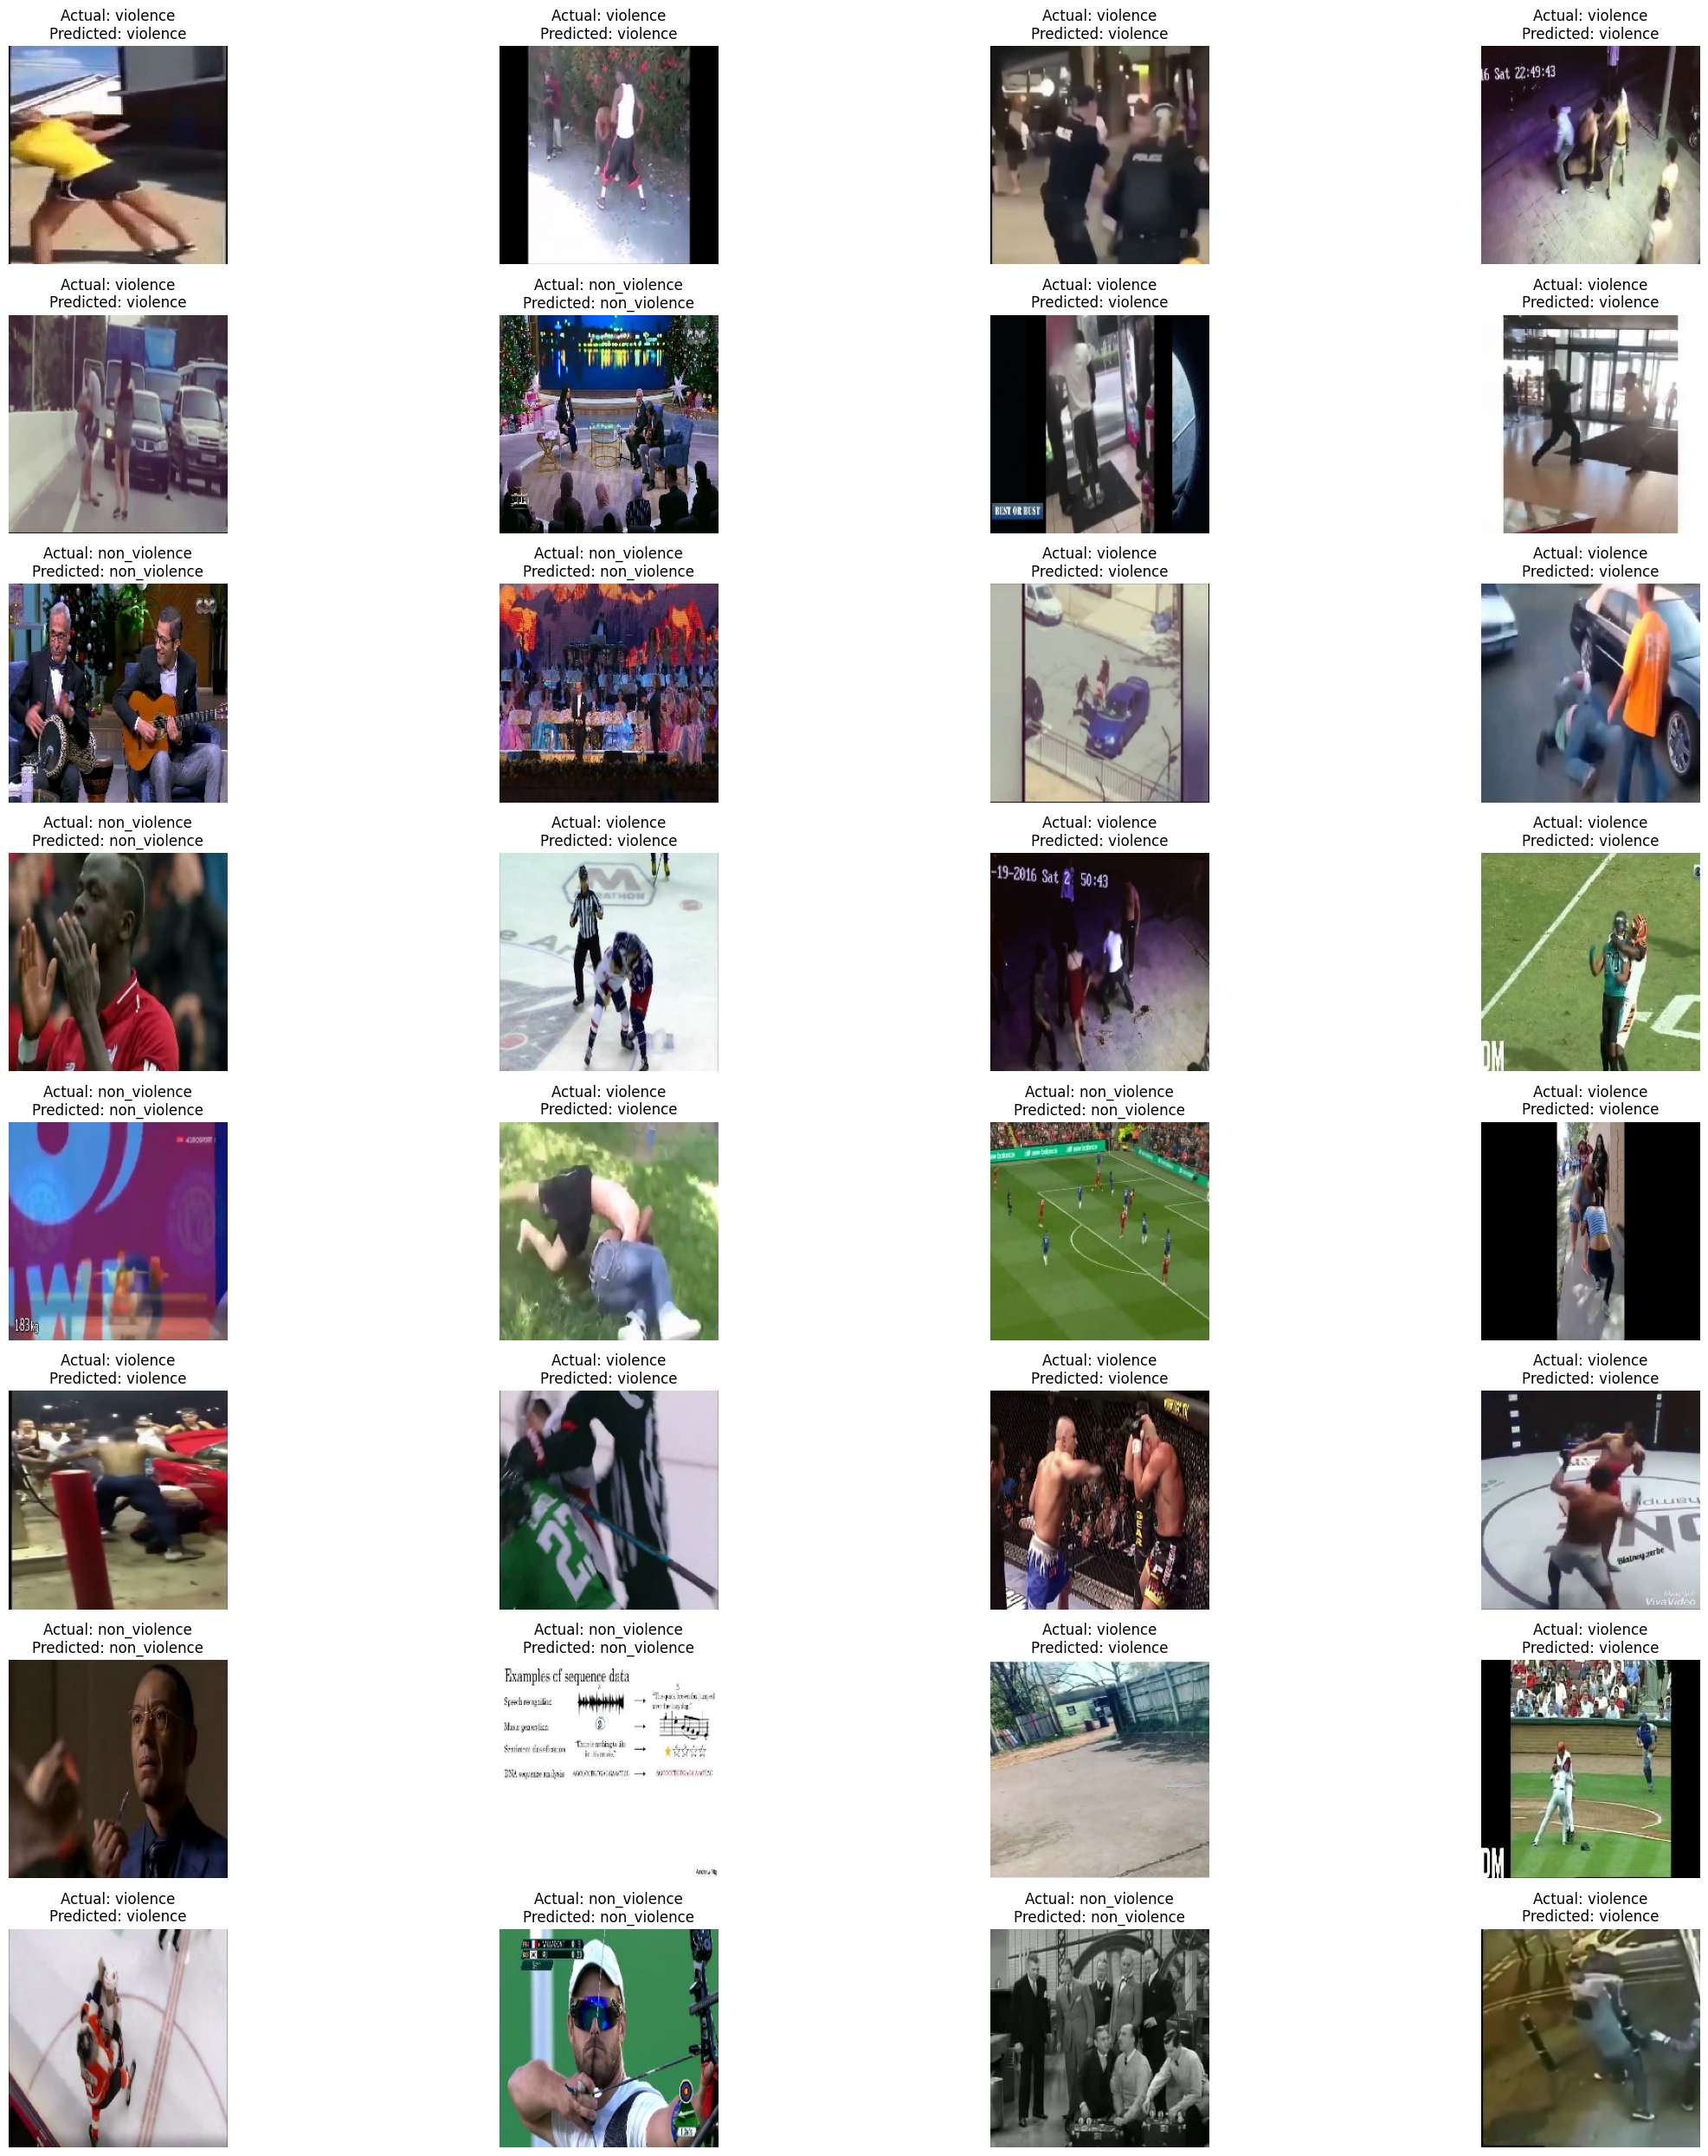

In [ ]:
plt.figure(figsize=(25, 25))
for i in range(32):  # Assumindo que você quer visualizar 32 imagens
    ax = plt.subplot(8, 4, i + 1)  # Configura 8 linhas e 4 colunas de imagens
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'Actual: {class_names[y_val[i]]}\nPredicted: {class_names[y_pred[i]]}')
    plt.axis("off")
plt.tight_layout()  # Ajusta o layout para que as imagens não se sobreponham
plt.show()

# Predições e Matriz de Confusão

In [ ]:
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

# Faça as previsões com o modelo e obtenha o índice da classe com a maior probabilidade


In [ ]:
predictions = keras_model.predict(np.array(X_val))
y_pred = np.argmax(predictions, axis=1)

df = pd.DataFrame({'Actual': y_val, 'Prediction': y_pred})

70/70 [==============================] - 28s 394ms/step


# Visualização das Previsões


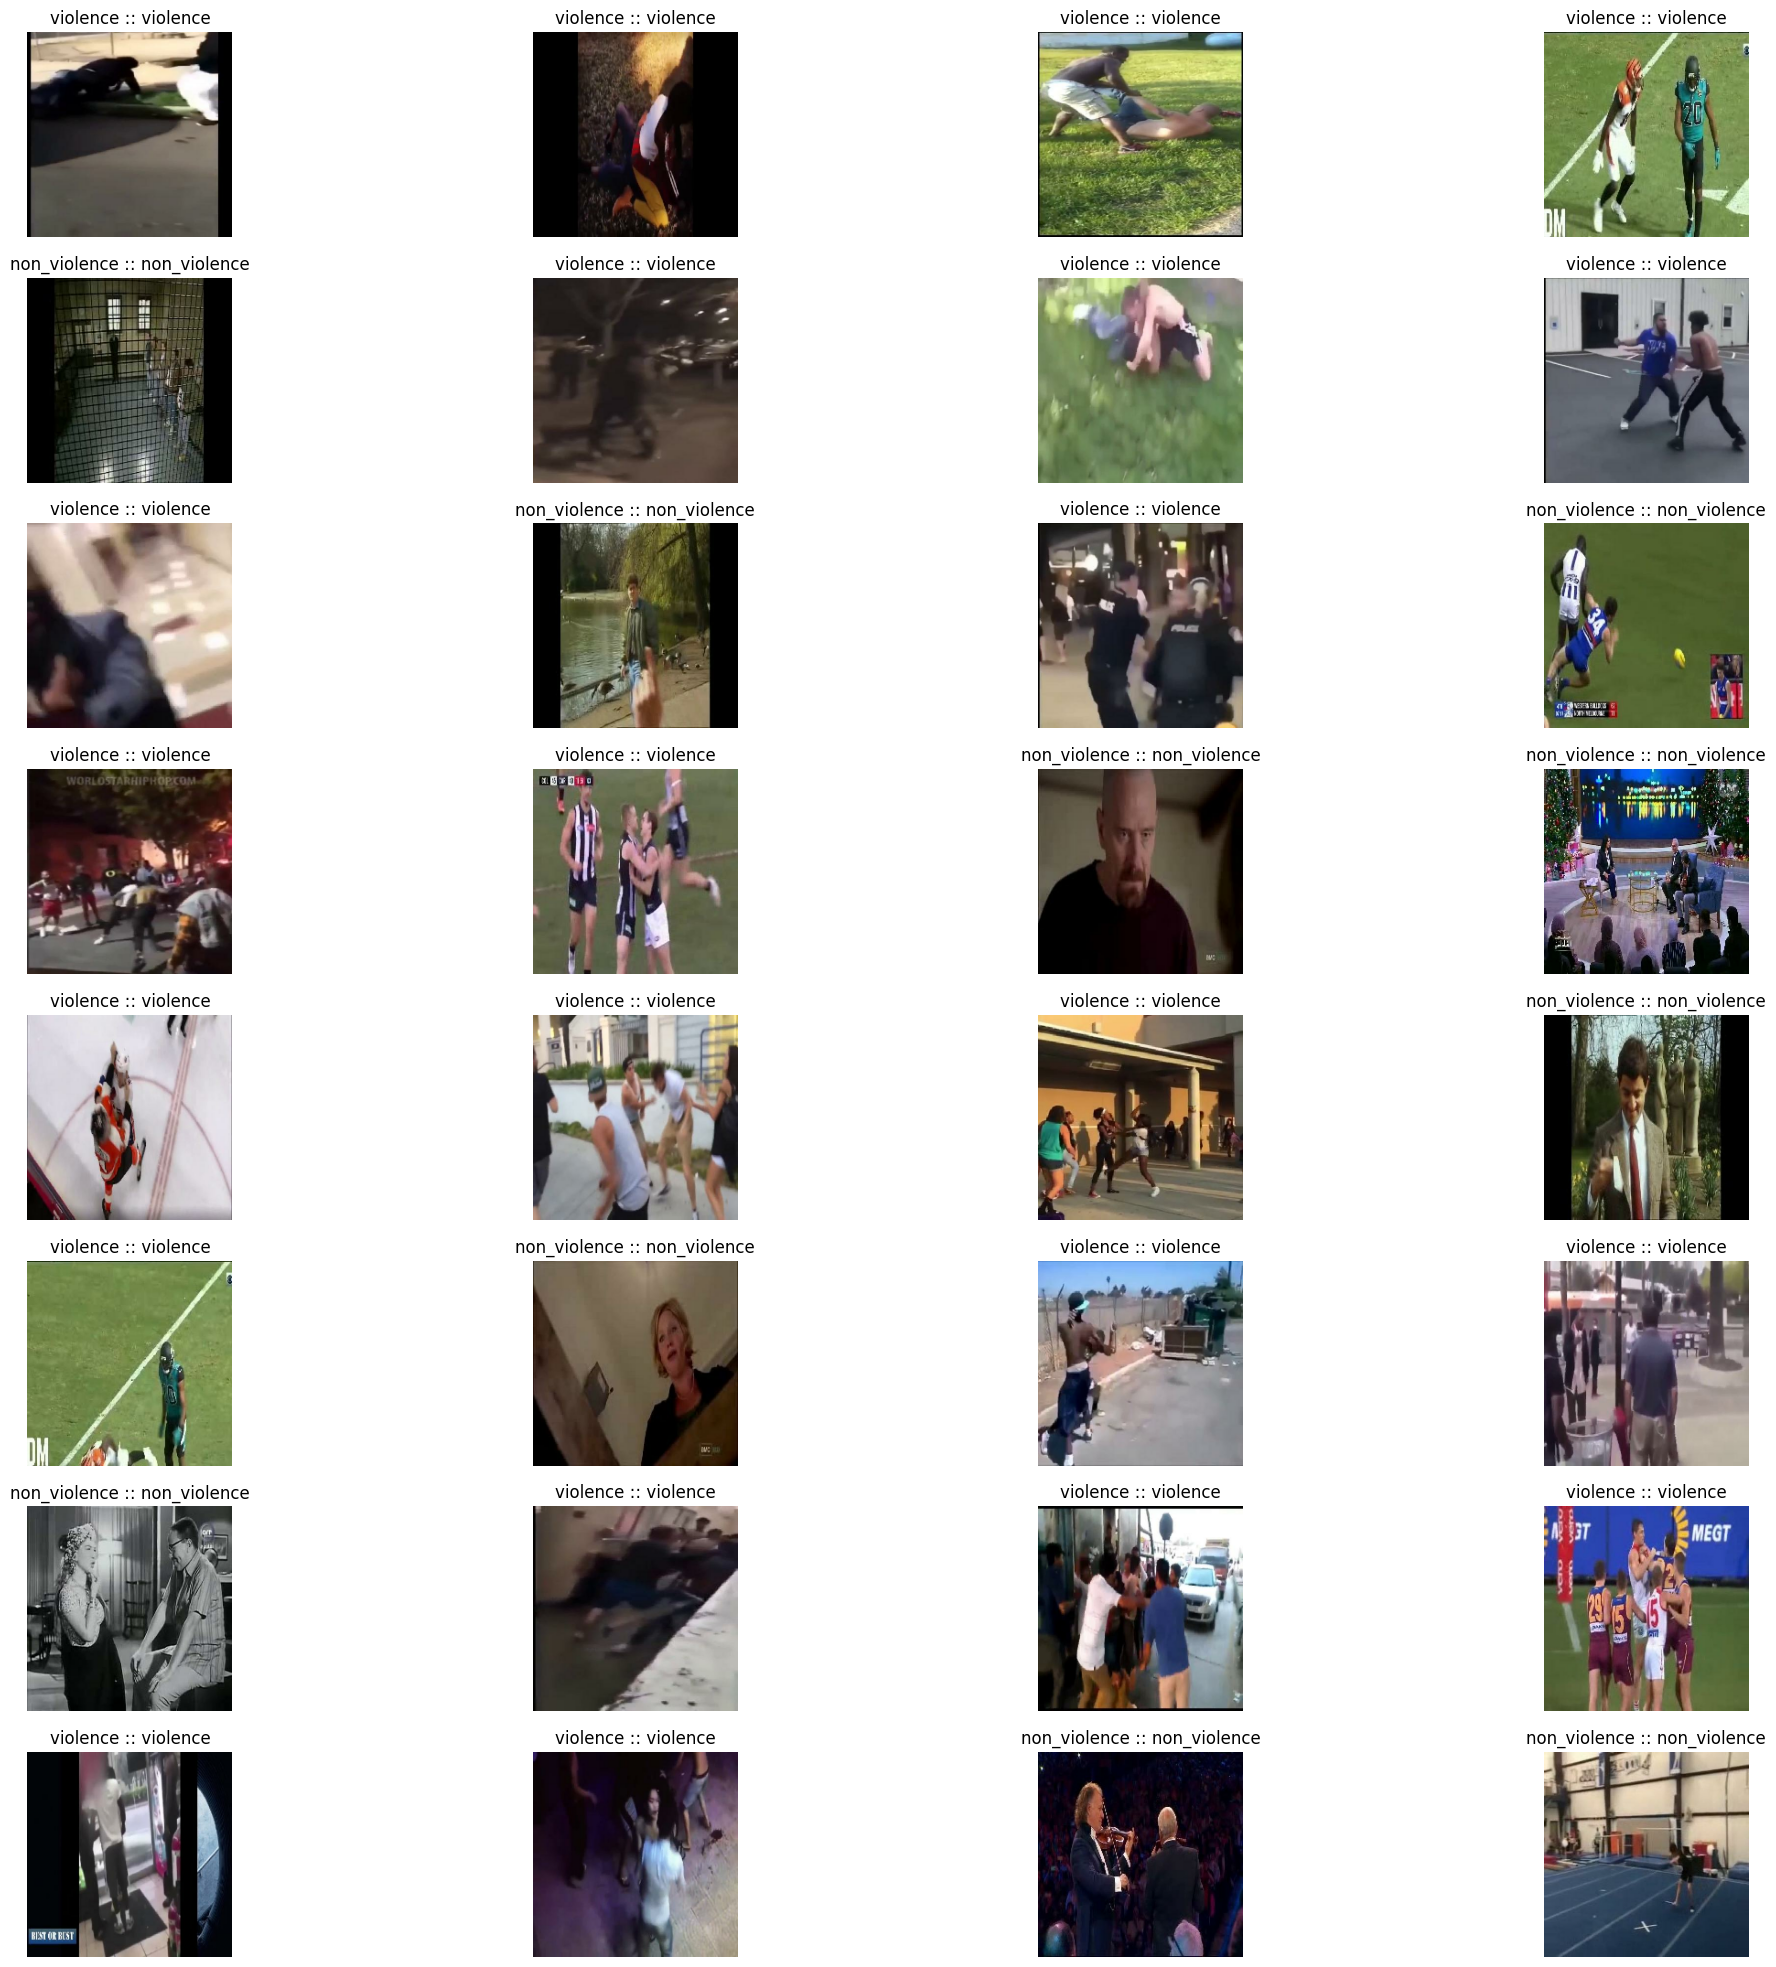

In [ ]:
plt.figure(figsize=(25, 25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")
plt.show()


# Matriz de Confusão


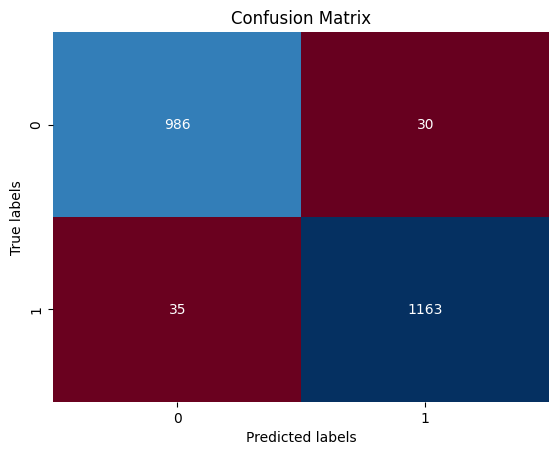

In [ ]:
ax = plt.subplot()
CM = confusion_matrix(y_val, y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax, cbar=False, cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

# Acurácia


In [ ]:
Acc = accuracy_score(y_val, y_pred)
print("Accuracy is: {0:.1f}%".format(Acc * 100))

Accuracy is: 97.1%


# **Testando Modelo**

Saving hnd-historia-violencia-domestica.png to hnd-historia-violencia-domestica (1).png


1/1 [==============================] - 1s 1s/step


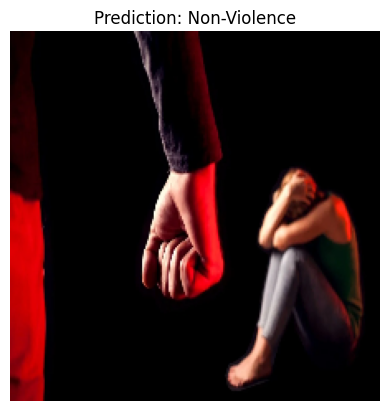

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt

# Carregue o modelo salvo do Google Drive
model_path_h5 = '/content/drive/My Drive/0-Dataset/Digital Surveillance/MobileNetV3Small.h5'
model = load_model(model_path_h5)

# Função para fazer a previsão
def predict_image(model, img):
    # Pré-processamento da imagem para o modelo
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Cria um batch que contém uma única imagem
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)  # Pré-processamento específico para MobileNetV3

    # Fazer a previsão
    prediction = model.predict(img_array)

    # Retorna o índice da classe de maior probabilidade
    return np.argmax(prediction, axis=1)[0]

# Interface de upload para o usuário carregar uma imagem
uploaded = files.upload()

# Predição e visualização
for filename in uploaded.keys():
    img_path = '/content/' + filename
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')

    # Faz a previsão
    prediction = predict_image(model, img)

    # Mostra o resultado
    if prediction == 0:
        plt.title("Prediction: Non-Violence")
    else:
        plt.title("Prediction: Violence")
    plt.show()
